# House Prices: Advanced Regression Techniques - Part I

In this notebook we build some simple baseline models and we build an initial XGBRegressor where we try using numerical, ordinal and categorical features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder
import warnings
import xgboost as xgb
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

train = pd.read_csv('kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_sub = pd.read_csv('kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

Set the minimum correlation with the target variable.

In [2]:
#min_corr = 0.00000
min_corr = 0.03125
#min_corr = 0.04000
#min_corr = 0.05000
#min_corr = 0.06250
#min_corr = 0.12500
#min_corr = 0.25000

In [3]:
def clean_extr_ord_cols(df):
    for col in ord_4lvls_cols:
        df[col] = df[col].map(ord_dict_4lvls)
    for col in ord_5lvls_cols:
        df[col] = df[col].map(ord_dict_5lvls)
    for col in ord_6lvls_cols:
        df[col] = df[col].map(ord_dict_6lvls)
    return df


def select_cols_min_corr(cols, min_corr):
    abs_corrs = abs(pd.concat([X[cols], y], axis = 1).corr(method = 'spearman')['SalePrice'])
    cols_sel = list(abs_corrs.loc[abs_corrs > min_corr].index)
    cols_sel.remove('SalePrice')
    return cols_sel


def get_train_val_sets(X, y, cols):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1)
    return X_train[cols], X_val[cols], y_train, y_val


def rmsle(y_true, y_pred): # Custom scoring function
    y_pred[y_pred < 0] = 0 # Replace negative predictions with 0.
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better = False)


def print_cv_val_score(my_s, print_best_est = True):    
    best_est = my_s.best_estimator_
    best_est.fit(X_train, y_train)
    y_pred = best_est.predict(X_val)
    val_score = rmsle(y_val, y_pred)
    best_CV_score = my_s.best_score_    
    print('Best CV score:', format(-best_CV_score, 'E'))
    print('Validation score:', format(val_score, 'E'))
    if print_best_est:
        print(best_est)


def get_sub_csv(my_s, cols, name_csv):
    best_est = my_s.best_estimator_
    #best_est.fit(X_train, y_train)
    best_est.fit(X[cols], y)
    X_test = test[cols]
    y_pred = best_est.predict(X_test)
    #y_pred = np.expm1(y_pred)
    test_submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':y_pred})
    test_submission.to_csv(name_csv, index=False)   

Set list of columns to drop with too many missing values (more than 10% missing).

In [4]:
max_fraction_null = 0.10
nrows = train.shape[0]
drop_cols = list(train.columns[train.isnull().sum() > nrows * max_fraction_null])
drop_cols

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

**COMMENT:** Some features, such as FireplaceQu, PoolQC, Fence and MiscFeature, might contain info relevant for more expensive objects.

**IDEA:** If it is apparent that the best model performs much worse for more expensive objects, maybe include these features (compare the performance of  < 50th vs > 50th percentile, or < 75th vs > 75th percentile).

Clean drop_cols.

In [5]:
drop_dict_2lvls = {'Grvl':0, 'Pave':1}
drop_dict_4lvls_PQC = {'Fa':0, 'TA':1, 'Gd':2, 'Ex':3}
drop_dict_4lvls_F = {'MnWw':0, 'GdWo':1, 'MnPrv':2, 'GdPrv':3}
drop_dict_5lvls = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

def clean_drop_cols(df):
    df['Alley'] = df['Alley'].map(drop_dict_2lvls)
    df['PoolQC'] = df['PoolQC'].map(drop_dict_4lvls_PQC)
    df['Fence'] = df['Fence'].map(drop_dict_4lvls_F)
    df['FireplaceQu'] = df['FireplaceQu'].map(drop_dict_5lvls)
    return(df)

train = clean_drop_cols(train)
test = clean_drop_cols(test)

Plot some drop_cols to see if they should be considered ordinal or categorical

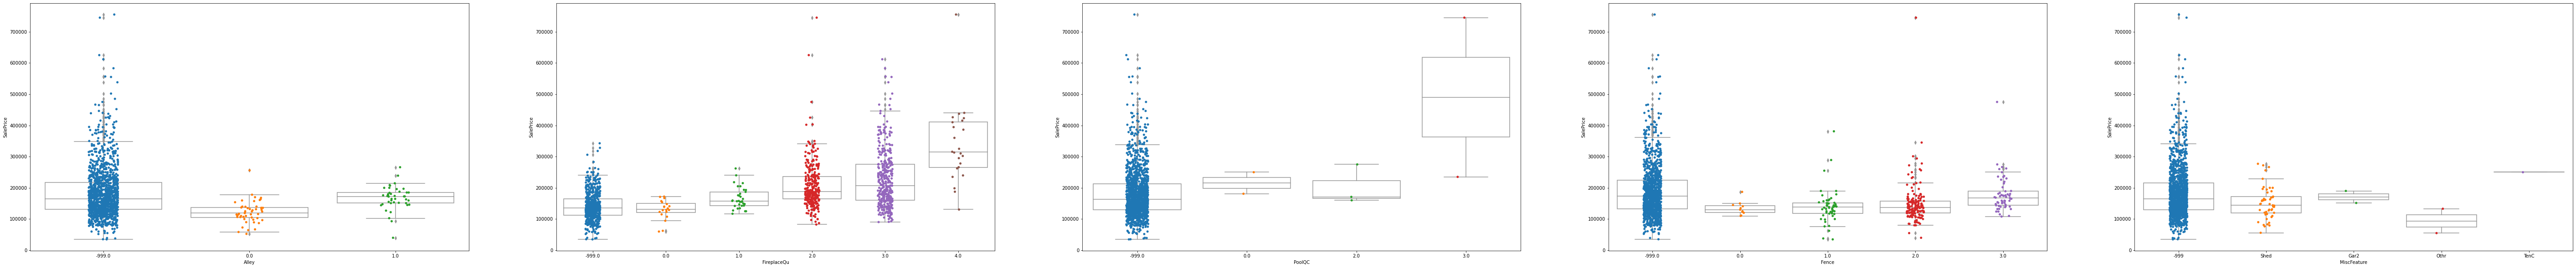

In [6]:
drop_cols_plot = drop_cols.copy()
drop_cols_plot.remove('LotFrontage')
fig, axes = plt.subplots(1, len(drop_cols_plot), figsize = (100, 10))
for i, col in enumerate(drop_cols_plot):
    sns.stripplot(data = train.fillna(-999), x = col, y = 'SalePrice', ax = axes.flat[i], jitter = True)
    sns.boxplot(data = train.fillna(-999), x = col, y = 'SalePrice', ax = axes[i], color = 'white')
    #sns.distplot(X[col], ax = axes.flat[i], kde = False)

In [7]:
train = train.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

Split train into training and validation sets.

In [8]:
X = train.drop(['Id', 'SalePrice'], axis = 1)
y = train['SalePrice']
#y = np.log1p(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1)

Plot the distribution of the target variable.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

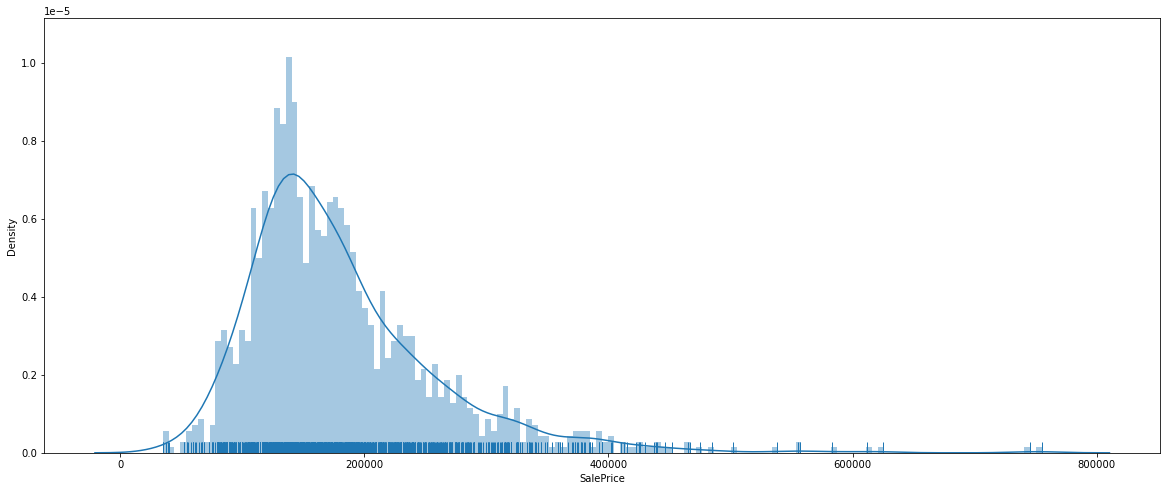

In [9]:
plt.figure(figsize = (20, 8))
sns.distplot(y, rug = True, kde = True, bins=150)

## Baseline Model I (Mean and Median)

In [10]:
print('Mean:', format(np.mean(train.SalePrice), 'E'))
print('Median:', format(np.median(train.SalePrice), 'E'))
strategies = ['mean', 'median']
for strategy in strategies:
    dummy_reg = DummyRegressor(strategy = strategy)    
    dummy_reg.fit(X_train, y_train)
    y_pred = dummy_reg.predict(X_val)
    val_score = rmsle(y_val, y_pred)
    print('Strategy:', strategy, '---> Validation score:', format(val_score, 'E'))

Mean: 1.809212E+05
Median: 1.630000E+05
Strategy: mean ---> Validation score: 4.356030E-01
Strategy: median ---> Validation score: 4.175191E-01


## Baseline Model II (Benchmark Submission)

In [11]:
benchmark_cols = ['LotArea', 'YrSold', 'MoSold', 'BedroomAbvGr']
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, benchmark_cols)

In [12]:
#sns.pairplot(pd.concat([X[benchmark_cols], y], axis = 1))

In [13]:
#sns.heatmap(pd.concat([X[benchmark_cols], y], axis = 1).corr(), cmap='RdBu_r', center=0.0)

Validation score without CV

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_val)
val_score = rmsle(y_val, y_pred)
print(' Validation score:', format(val_score, 'E'))

 Validation score: 4.103279E-01


Validation score with CV and hyperparameter tuning

In [15]:
my_s = GridSearchCV(lin_reg, param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}, cv = 5, scoring = rmsle_scorer)
my_s = my_s.fit(X_train, y_train)
print_cv_val_score(my_s)

Best CV score: 3.771911E-01
Validation score: 4.101092E-01
LinearRegression(fit_intercept=False, normalize=True)


In [16]:
#get_sub_csv(my_s, benchmark_cols, 'linreg_sub.csv')

## Model I - Numeric (including automatically extracted ordinal) features

In [17]:
#set(train.dtypes)

In [18]:
num_cols = list(X.select_dtypes(np.number).columns)
temp = num_cols.copy()
for element in ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', \
                '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', \
                'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']:
    temp.remove(element)

**Comments:**
* MSSubClass: Identifies the type of dwelling involved in the sale - this is in fact a categorical feature and should be removed from num_cols.
* YearRemodAdd: Remodel date (same as construction date if no remodeling or additions) - perhaps better to define a new feature; DiffYearBuilt_RemodAdd = YearRemodAdd - YearBuilt
* MasVnrArea: Masonry veneer area in square feet - 8 NAs but 0s are also present so should be OK to impute NAs.
* 1stFlrSF: First Floor square feet and 2ndFlrSF: Second floor square feet - 2ndFlrSF is OK as it is 0 when there is no 2nd floor (no NAs in any of the features) 
* GarageYrBlt: Year garage was built - 81 NAs are present since some houses have no garage, so it makes no sense to impute the NAs. Should we replace NA with -999? From "Winning a Kaggle Competition in Python" Ch. 3: "Ex: Constant value imputation; -999. Not a good choice for linear models but works perfectly for tree-based models." Constant value imputation of this kind must be done separately in the pipeline for this feature (and possibly others). Maybe not however, should be OK to do it beforehand for both train (or X) and test. 
* GarageCars: Size of garage in car capacity - no NAs are present but 81 0s.
* GarageArea: Size of garage in square feet - no NAs are present but 81 0s.
* PoolArea: Pool area in square feet - no NAs but 1453 0s. Perhaps this is all the info needed regarding the possession of pools? Maybe we can define HasPool:0 if PoolArea == 0 and HasPool:1 if PoolArea > 0?
* MoSold: Month Sold (MM) - not really an ordinal feature but might still contain valuable info; perhaps more expensive houses are sold during certain periods? Could maybe be combined with YrSold to form a new feature. 
* Total time period covered in the dataset: 2006-01 - 2010 -07.

Remove MSSubClass since it is a categorical feature.

In [19]:
num_cols.remove('MSSubClass')

Apply minimum correlation filter to num_cols.

In [20]:
#num_cols = select_cols_min_corr(num_cols, min_corr)

Replace NAs in GarageYrBlt with -999.

In [21]:
#X['GarageYrBlt'] = X['GarageYrBlt'].fillna(-999)
#test['GarageYrBlt'] = test['GarageYrBlt'].fillna(-999)

In [22]:
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols)

In [23]:
#sns.pairplot(pd.concat([X[num_cols], y], axis = 1), corner = True)
#sns.pairplot(pd.concat([X[['MSSubClass', 'PoolArea', 'MoSold', 'YrSold']], y], axis = 1), corner = True)

In [24]:
#plt.figure(figsize = (20, 8))
#sns.heatmap(pd.concat([X[num_cols], y], axis = 1).corr(), cmap='RdBu_r', center=0.0)

Build the Pipeline() and the meta-estimator (TransformedTargetRegressor())

In [25]:
steps = [('imputer', SimpleImputer(fill_value = -999)),
         ('scaler', None),         
        ('model', None)]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, transformer = None)

We only use XGBoost in this notebook.

In [26]:
xgbr = XGBRegressor(objective = 'reg:squarederror', random_state = 1) # How should objective be set? Custom objective function?
#xgbr = XGBRegressor(objective = 'reg:squaredlogerror', random_state = 1)

param_grid = [{'regressor__imputer__strategy': ['most_frequent', 'mean', 'median', 'constant'],
               'regressor__scaler': [None, StandardScaler(), RobustScaler()],
               #'regressor__scaler': [None],
               'regressor__model': [xgbr],               
               'transformer': [None, StandardScaler(), RobustScaler()]}]

my_s = GridSearchCV(ttr, param_grid = param_grid, cv = 5, scoring = rmsle_scorer, n_jobs = -1, verbose = 10)

In [27]:
#my_s = my_s.fit(X_train, y_train)

In [28]:
#print_cv_val_score(my_s, print_best_est = True)

In [29]:
#name = 'xgbr_sub_num_min_corr' + str(min_corr ) + '.csv'
#get_sub_csv(my_s, num_cols, name)

## Model II - Numeric + manually extracted ordinal features

In [30]:
obj_cols = list(X.select_dtypes('O').columns)
temp = obj_cols.copy()
for element in ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', \
                'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', \
                'PavedDrive', 'SaleType', 'SaleCondition']:
    temp.remove(element)
extr_ord_cols = temp

**COMMENTS:** 
* We might consider Utilities, Functional, GarageFinish and PavedDrive as ordinal features.
* Features that have NAs should be imputed with -999 since NA implies that the house does not have a basement or garage.
* BsmtQual: Evaluates the height of the basement - Is no basement worse than a poor basement? Probably not.

Map the levels in extr_ord_cols to ordinal quantities.

In [31]:
temp = extr_ord_cols.copy()
for element in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']:
    temp.remove(element)

In [32]:
ord_dict_4lvls = {'No':0, 'Mn':1, 'Av':2, 'Gd':3}
ord_dict_5lvls = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
ord_dict_6lvls = {'Unf':0, 'LwQ':1, 'Rec': 2, 'BLQ':3, 'ALQ':4, 'GLQ':5}

ord_4lvls_cols = ['BsmtExposure']
ord_5lvls_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
ord_6lvls_cols = ['BsmtFinType1', 'BsmtFinType2']

def clean_extr_ord_cols(df):
    for col in ord_4lvls_cols:
        df[col] = df[col].map(ord_dict_4lvls)
    for col in ord_5lvls_cols:
        df[col] = df[col].map(ord_dict_5lvls)
    for col in ord_6lvls_cols:
        df[col] = df[col].map(ord_dict_6lvls)
    return df

X = clean_extr_ord_cols(X)
test = clean_extr_ord_cols(test)

In [33]:
#sns.pairplot(pd.concat([X[extr_ord_cols], y], axis = 1), corner = True)

Set supplementary manually extracted ordinal features.

In [34]:
supp_extr_ord_cols = ['Utilities', 'Functional', 'GarageFinish', 'PavedDrive']

supp_ord_dict_3lvls_GF = {'Unf':0, 'RFn':1, 'Fin':2}
supp_ord_dict_3lvls_PD = {'N':0, 'P':1, 'Y':2}
supp_ord_dict_4lvls = {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3}
supp_ord_dict_8lvls = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2': 5, 'Min1':6, 'Typ':7}

def clean_supp_extr_ord_cols(df):    
    df['GarageFinish'] = df['GarageFinish'].map(supp_ord_dict_3lvls_GF)
    df['PavedDrive'] = df['PavedDrive'].map(supp_ord_dict_3lvls_PD)
    df['Utilities'] = df['Utilities'].map(supp_ord_dict_4lvls)
    df['Functional'] = df['Functional'].map(supp_ord_dict_8lvls)
    return df

X = clean_supp_extr_ord_cols(X)
test = clean_supp_extr_ord_cols(test)

In [35]:
#sns.pairplot(pd.concat([X[supp_extr_ord_cols], y], axis = 1), corner = True)

**COMMENTS:** 
* It seems reasonable to consider these features ordinal.
* Only GarageFinish has NAs (81), i.e. houses without garage (replace with -999).

In [36]:
#plt.figure(figsize = (20, 10))
#sns.heatmap(pd.concat([X[num_cols + extr_ord_cols + supp_extr_ord_cols], y], axis = 1).corr(method = 'spearman'), cmap='RdBu_r', center=0.0)

Sort and plot the correlations of the features to the target variable.

In [37]:
#corrs = pd.concat([X[num_cols + extr_ord_cols + supp_extr_ord_cols], y], axis = 1).corr(method = 'spearman')['SalePrice']
#plt.figure(figsize = (20, 8))
#corrs.sort_values().plot.bar()

****Comment:**** It's strange that we get a negative correlation for OverallCond even though it should be positively correlated with the target variable.

In [38]:
#sns.pairplot(pd.concat([X[['OverallCond', 'OverallQual']], y], axis = 1), corner = True)

Apply minimum correlation filter to extr_ord_cols + supp_extr_ord_cols.

In [39]:
#extr_ord_cols = select_cols_min_corr(extr_ord_cols, min_corr)
#supp_extr_ord_cols = select_cols_min_corr(supp_extr_ord_cols, min_corr)

Replace NAs with -999 in extr_ord_cols and supp_extr_ord_cols

In [40]:
#X[extr_ord_cols] = X[extr_ord_cols].fillna(-999)
#test[extr_ord_cols] = test[extr_ord_cols].fillna(-999)

#X[supp_extr_ord_cols] = X[supp_extr_ord_cols].fillna(-999)
#test[supp_extr_ord_cols] = test[supp_extr_ord_cols].fillna(-999)

Restructure {num_cols + extr_ord_cols + supp_extr_ord_cols} into {num_cols + ord_cols}.

In [41]:
temp = num_cols.copy()
num_cols_keep = []
ord_cols = []

for element in ['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']:
    num_cols_keep.append(element)
    temp.remove(element)

for element in ['OverallQual', 'OverallCond']:
    ord_cols.append(element)
    temp.remove(element)

**COMMENT:** Many features, such as BsmtFullBath, have a limited no. values ({0, 1, 2, 3}). Replace with HasFullBath = True/False?

Set num_cols and ord_cols.

In [42]:
num_cols = num_cols_keep
ord_cols = ord_cols +  extr_ord_cols + supp_extr_ord_cols

In [43]:
print('No. features before minimum correlation filter:', len(num_cols) + len(ord_cols))

No. features before minimum correlation filter: 49


In [44]:
set_num_cols = set(num_cols)
set_ord_cols = set(ord_cols)
set_num_cols_f = set(select_cols_min_corr(num_cols, min_corr))
set_ord_cols_f = set(select_cols_min_corr(ord_cols, min_corr))
print('Features removed from num_cols:', set_num_cols.difference(set_num_cols_f))
print('Features removed from ord_cols:', set_ord_cols.difference(set_ord_cols_f))

Features removed from num_cols: {'YrSold', 'BsmtHalfBath'}
Features removed from ord_cols: {'ExterCond', 'Utilities'}


Apply minimum correlation filter to num_cols + ord_cols.

In [45]:
num_cols = select_cols_min_corr(num_cols, min_corr)
ord_cols = select_cols_min_corr(ord_cols, min_corr)

In [46]:
print('No. features after minimum correlation filter:', len(num_cols) + len(ord_cols))

No. features after minimum correlation filter: 45


Replace YearRemodAdd with DiffYearRemodAddBuilt

In [47]:
#X['DiffYearRemodAddBuilt'] = X['YearRemodAdd'] - X['YearBuilt']
#test['DiffYearRemodAddBuilt'] = test['YearRemodAdd'] - test['YearBuilt']
#sns.pairplot(pd.concat([X[['YearBuilt', 'YearRemodAdd', 'DiffYearRemodAddBuilt']], y], axis = 1), corner = True)
#num_cols.remove('YearRemodAdd')
#num_cols.append('DiffYearRemodAddBuilt')

**Comment:** The  test score was not improved when DiffYearRemodAddBuilt was introduced.

Replace NAs

In [48]:
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(-999)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(-999)

X[extr_ord_cols] = X[extr_ord_cols].fillna(-999)
test[extr_ord_cols] = test[extr_ord_cols].fillna(-999)

X[supp_extr_ord_cols] = X[supp_extr_ord_cols].fillna(-999)
test[supp_extr_ord_cols] = test[supp_extr_ord_cols].fillna(-999)

Plot categorical plots of ord_cols to see if it might be worth using -1 instead of -999 (so that StandardScaler() is not used)

In [49]:
#fig, axes = plt.subplots(1, len(ord_cols), figsize = (100, 10))
#for i, col in enumerate(ord_cols):
#    sns.stripplot(data = pd.concat([X[ord_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[i], jitter = True, alpha = 1)
#    sns.boxplot(data = pd.concat([X[ord_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[i])  

**Comments:** 
* It should probably be OK to replace -999 with -1, and in some cases switch places with -1 and 0 (e.g., having no basement is better than having a bad basement).
* Implementing these changes did not improve the test score and StandardScaler() was still used.

In [50]:
#X['BsmtQual'] = X['BsmtQual'].fillna(0)
#test['BsmtQual'] = test['BsmtQual'].fillna(0)

#cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageCond', 'GarageFinish']
#for col in cols:
#    X[col] = X[col].fillna(-1)
#    test[col] = test[col].fillna(-1)
    
#cols = ['BsmtCond', 'GarageQual']
#for col in cols:
#    X[col] = X[col].replace(0, -1)
#    X[col] = X[col].fillna(0)
#    test[col] = test[col].replace(0, -1)
#    test[col] = test[col].fillna(0)

Take the logarithm of LotArea and MasVnrArea.

In [51]:
X['LotArea'] = np.log(X['LotArea'])
test['LotArea'] = np.log(test['LotArea'])

#X['MasVnrArea'] = np.log1p(X['MasVnrArea'])
#test['MasVnrArea'] = np.log1p(test['MasVnrArea'])

In [52]:
#X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + extr_ord_cols)
#X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + extr_ord_cols + supp_extr_ord_cols)
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + ord_cols)

Build the pipeline with ColumnTransformer()

In [53]:
#preprocessor = ColumnTransformer([
#            ('scaler_num_cols', None, slice(0, len(num_cols))),
#            ('scaler_extr_ord_cols', None, slice(len(num_cols), len(num_cols + extr_ord_cols)))])

#preprocessor = ColumnTransformer([
#            ('scaler_num_cols', None, slice(0, len(num_cols))),
#            ('scaler_extr_ord_cols', None, slice(len(num_cols), len(num_cols + extr_ord_cols + supp_extr_ord_cols)))])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', None, slice(0, len(num_cols))),
            ('scaler_ord_cols', None, slice(len(num_cols), len(num_cols + ord_cols)))])


steps = [('imputer', SimpleImputer(fill_value = -999)),
         ('preprocessor', preprocessor),         
        ('model', None)]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, transformer = None)

We continue using an XGBoost model.

In [54]:
xgbr = XGBRegressor(objective = 'reg:squarederror', random_state = 1) 

#param_grid = [{'regressor__imputer__strategy': ['most_frequent', 'mean', 'median', 'constant'],
#               'regressor__preprocessor__scaler_num_cols': [None, StandardScaler(), RobustScaler()],
#               'regressor__preprocessor__scaler_extr_ord_cols': [None, StandardScaler(), RobustScaler()],
#               'regressor__model': [xgbr],               
#               'transformer': [None, StandardScaler(), RobustScaler()]}]

param_grid = [{'regressor__imputer__strategy': ['most_frequent', 'mean', 'median', 'constant'],
               'regressor__preprocessor__scaler_num_cols': ['passthrough', StandardScaler(), RobustScaler()],
               'regressor__preprocessor__scaler_ord_cols': ['passthrough', StandardScaler(), RobustScaler()],
               'regressor__model': [xgbr],               
               'transformer': [None, StandardScaler(), RobustScaler()]}]               

my_s = GridSearchCV(ttr, param_grid = param_grid, cv = 5, scoring = rmsle_scorer, n_jobs = -1, verbose = 10)

In [55]:
#my_s = my_s.fit(X_train, y_train)

In [56]:
#print_cv_val_score(my_s, print_best_est = True)

Examine which scalers were chosen.

In [57]:
#my_s.best_estimator_.regressor.named_steps

In [58]:
#name = 'xgbr_sub_num_extr_ord_min_corr' + str(min_corr ) + '.csv'
#get_sub_csv(my_s, num_cols + extr_ord_cols, name)
#get_sub_csv(my_s, num_cols + extr_ord_cols + supp_extr_ord_cols, name)

#name = 'xgbr_sub_num_ord_min_corr' + str(min_corr ) + '.csv'
#get_sub_csv(my_s, num_cols + ord_cols, name)

## Model III - Numeric + ordinal + categorical features

Consider candidates of num_cols to be represented as categorical features

In [59]:
#fig, axes = plt.subplots(1, len(num_cols), figsize = (110, 5))
#for i, col in enumerate(num_cols):
#    sns.distplot(X[col], ax = axes.flat[i], kde = False)

In [60]:
#sns.distplot(X['GarageYrBlt'].replace(-999, np.NaN), kde = False)

In [61]:
candidates = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [62]:
#g = sns.pairplot(data = pd.concat([X[num_cols], y], axis = 1), x_vars = num_cols, y_vars = 'SalePrice')

Set PoolArea as a categorical feature and remove it from num_cols

In [63]:
#X['HasPool'] = X['PoolArea'] > 0
#X['HasPool'] = X['HasPool'].astype(int)
#test['HasPool'] = test['PoolArea'] > 0
#test['HasPool'] = test['HasPool'].astype(int)
#num_cols.remove('PoolArea')

**Comment:** I'm not sure this is such a good approach, we simply reduce the information available for the model, and the model can probably choose itself what it needs or can extract from the data.

Try some categorical features (one at a time).

In [64]:
cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', \
            'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'SaleType', \
            'SaleCondition']
cat_cols = cat_cols + ['MiscFeature'] # Feature from drop_cols that could be considered categorical.
print('No. categorical features:', len(cat_cols))

No. categorical features: 28


In [65]:
#fig, axes = plt.subplots(1, len(cat_cols), figsize = (150, 10))
#fig, axes = plt.subplots(3, int(len(cat_cols) / 3), figsize = (60, 20))
#for i, col in enumerate(cat_cols):
    #sns.stripplot(data = pd.concat([X[cat_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes.flat[i], jitter = True)
    #sns.boxplot(data = pd.concat([X[cat_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[i], color = 'white')
    #sns.distplot(X[col], ax = axes.flat[i], kde = False)

Define the list of categorical features used in the model.

In [66]:
#cat_cols = ['HasPool']
#cat_cols = ['CentralAir']
cat_cols = ['Street']
#cat_cols = ['CentralAir', 'Street']



In [67]:
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + ord_cols + cat_cols)

Build the pipeline with ColumnTransformer() for cat_cols.

In [68]:
imputer = ColumnTransformer([
    ('imputer_num_ord_cols', SimpleImputer(fill_value = -999), slice(0, len(num_cols + ord_cols))),
    ('imputer_cat_cols', SimpleImputer(strategy = 'most_frequent'), slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', None, slice(0, len(num_cols))),
            ('scaler_ord_cols', None, slice(len(num_cols), len(num_cols + ord_cols)))
            #('category_encoder_cat_cols', None, slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
], remainder = 'drop') # Temporary solution so that the model can be built withou cat. features.

steps = [('imputer', imputer),
         ('preprocessor', preprocessor),         
        ('model', None)]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, transformer = None)
#ttr = TransformedTargetRegressor(regressor = pipeline, func = np.log1p, inverse_func = np.expm1 )

In [69]:
xgbr = XGBRegressor(objective = 'reg:squarederror', random_state = 1)

#param_grid = [{'regressor__imputer__imputer_num_ord_cols__strategy': ['most_frequent', 'mean', 'median', 'constant'],
#               'regressor__preprocessor__scaler_num_cols': ['passthrough', StandardScaler(), RobustScaler()],
#               'regressor__preprocessor__scaler_ord_cols': ['passthrough', StandardScaler(), RobustScaler()],               
#               #'regressor__preprocessor__category_encoder_cat_cols': [OneHotEncoder()],
#               #'regressor__preprocessor__category_encoder_cat_cols__drop': [None, 'first'], # None was chosen anyway after gridsearch, and it is better not to use it.
#               'regressor__model': [xgbr],               
#               'transformer': [None, StandardScaler(), RobustScaler()]}]

#The best pipeline
param_grid = [{'regressor__imputer__imputer_num_ord_cols__strategy': ['mean'],
               'regressor__preprocessor__scaler_num_cols': ['passthrough'],
               'regressor__preprocessor__scaler_ord_cols': [StandardScaler()],               
               #'regressor__preprocessor__category_encoder_cat_cols': [OneHotEncoder()],
               #'regressor__preprocessor__category_encoder_cat_cols__drop': [None, 'first'], # None was chosen anyway after gridsearch, and it is better not to use it.
               'regressor__model': [xgbr],               
               'transformer': [StandardScaler()]}]    

my_s = GridSearchCV(ttr, param_grid = param_grid, cv = 5, scoring = rmsle_scorer, n_jobs = -1, verbose = 10)
#my_s = GridSearchCV(ttr, param_grid = param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 10)

In [70]:
my_s = my_s.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [71]:
print_cv_val_score(my_s, print_best_est = True)

Best CV score: 1.433268E-01
Validation score: 1.469366E-01
TransformedTargetRegressor(regressor=Pipeline(steps=[('imputer',
                                                      ColumnTransformer(transformers=[('imputer_num_ord_cols',
                                                                                       SimpleImputer(fill_value=-999),
                                                                                       slice(0, 45, None)),
                                                                                      ('imputer_cat_cols',
                                                                                       SimpleImputer(strategy='most_frequent'),
                                                                                       slice(45, 46, None))])),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('scaler_num_cols',
               

Examine which scalers were chosen.

In [72]:
#my_s.best_estimator_.regressor.named_steps

In [73]:
#name = 'xgbr_sub_num_ord_cat_min_corr' + str(min_corr ) + '.csv'
#print(name)
#get_sub_csv(my_s, num_cols + ord_cols + cat_cols, name)

Perform hyperparameter tuning of the XGBRegressor()

In [74]:
best_pipeline = my_s.best_estimator_

param_grid = [
              #{'regressor__model__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500], # Require too much memory, cannot even run it on my\
               #computer
              {'regressor__model__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
               'regressor__model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
               'regressor__model__alpha': [0, 1, 10, 100],
               'regressor__model__lambda': [0, 1, 10, 100],
               'regressor__model__subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
               'regressor__model__colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
               'regressor__model__loss': ['ls', 'lad', 'huber', 'quantile'],               
               'regressor__model__learning_rate': [0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
               'regressor__model__max_features': [2, 'log2', 'sqrt', 'auto'],
               'regressor__model__min_samples_leaf': [1, 3, 5],
               'regressor__model__min_samples_split': [2, 4, 8]              
              }]               

#Best choice of hyp params so far
param_grid = [{'regressor__model__subsample': [0.5],
    'regressor__model__n_estimators': [350],
    'regressor__model__min_samples_split': [8],
    'regressor__model__min_samples_leaf': [3],
    #'regressor__model__max_features': ['log2, sqrt'],
    'regressor__model__max_depth': [5],
    'regressor__model__loss': ['lad'],
    'regressor__model__learning_rate': [0.02],
    'regressor__model__lambda': [0],
    'regressor__model__colsample_bytree': [0.5],
    'regressor__model__alpha': [0]}]

my_s_model_hyp_opt = GridSearchCV(best_pipeline, param_grid = param_grid, cv = 5, scoring = rmsle_scorer, n_jobs = -1, verbose = 10)
#my_s_model_hyp_opt = RandomizedSearchCV(best_pipeline, param_distributions = param_grid, cv = 5, scoring = rmsle_scorer, verbose = 10, random_state = 1, n_iter=10**5, n_jobs = -1)

In [75]:
my_s_model_hyp_opt = my_s_model_hyp_opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:18:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { loss, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [76]:
print_cv_val_score(my_s_model_hyp_opt, print_best_est = True)

[10:18:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { loss, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best CV score: 1.290710E-01
Validation score: 1.307719E-01
TransformedTargetRegressor(regressor=Pipeline(steps=[('imputer',
                                                      ColumnTransformer(transformers=[('imputer_num_ord_cols',
                                                                                       SimpleImputer(fill_value=-999),
                                                                                       slice(0, 45, None)),
                                                                                      ('imputer_cat_cols',
   

In [77]:
#my_s_model_hyp_opt.best_estimator_.regressor_.named_steps.model

In [78]:
#my_s_model_hyp_opt.best_params_

In [79]:
#name = 'xgbr_sub_num_ord_cat_model_hyp_opt_min_corr' + str(min_corr ) + '.csv'
#print(name)
#get_sub_csv(my_s_model_hyp_opt, num_cols + ord_cols + cat_cols, name)

## Log
Removing MSSubClass from num_cols does not improve the val. score but does improve the test score; from 0.156 to 0.155 (advanced 67 places on the leaderboard).

Replacing NAs in GarageYrBlt with -999 improves the val. score; from 0.144 to 0.143, and improves the test score; from 0.155 to 0.152 (advanced 112 places on the leaderboard).

Adding extr_ord cols improves the val. score but; from 0.143 to 0.142 but does not improve the test score; from 0.152 to 0.156. This was done with the same scaler for all features, which obviously is not suitable.

Having separate scalers for num_cols and extr_ord_cols did not improve any of the results.

Apply min correlation filter - could we miss important non-linear relationships if we do this?
Applying min_corr = 0.0625 to num_cols did not improve the test score.
Applying min_corr = 0.1250 to num_cols + extr_ord_cols did not improve the test score.

**Update 2020-05-08:** Must set rmsle_scorer = make_scorer(rmsle, greater_is_better = False), since by default greater_is_better = True. All the old results are invalid and must be redone.

**num_cols**

Keep MSSubClass ---> CV: 0.144, Val: 0.152, Test: 0.15425

Remove MSSubClass ---> CV:0.146, Val: 0.144, Test: 0.15220 (better)

Replace 'reg:squarederror' with 'reg:squaredlogerror' in XGBRegressor() ---> CV: 5.79, Val: 5.65, Test: 5.67178 (much worse - why?)

**num_cols + extr_ord_cols**

Add extr_ord_cols ---> CV: 0.143, Val: 0.136, Test: 0.14729 (better) 
**Note:** For num_cols RobustScaler() was chosen, and for extr_ord_cols StandardScaler() was chosen (makes sense) ---> Should restructure {num_cols, extr_ord_cols} into {num_cols, ord_cols}.

**num_cols + extr_ord_cols + supp_extr_ord_cols**

Add supp_extr_ord_cols ---> CV: 0.143, Val: 0.137, Test: 0.14806 (worse)

**num_cols + ord_cols**

Restructure into num_cols + ord_cols ---> CV: 0.144, Val: 0.137, Test: 0.14853 (worse)

Apply min_corr = 0.25 ---> CV: 0.150, Val: 0.159, Test: 0.16437 (worse)

Apply min_corr = 0.125 ---> CV: 0.145, Val: 0.146, Test: 0.15502 (worse)

Apply min_corr = 0.0625 ---> CV: 0.145, Val: 0.140, Test: 0.14952 (worse)

Apply min_corr = 0.03125 ---> CV: 0.144, Val: 0.147, Test: 0.14692 (better)
**Note:** StandardScaler() was used for both num_cols and ord_cols.

Fixed small bug - changed None to 'passthrough' in ColumnTransformer() ---> CV: 0.144, Val: 0.147, Test: 0.14693 (slightly worse but this is correct)
**Note:** 'passthrough' was chosen for num_cols, and StandardScaler() was chosen for ord_cols.

np.log of LotArea ---> CV: 0.143, Val: 0.147, Test: 0.14693 (same score as before, so can probably keep it)

np.log1p of MasVnrArea ---> CV: 0.144, Val: 0.147, Test: 0.14737 (worse, so will not keep it)

**num_cols + ord_cols + cat_cols**

Convert PoolArea to HasPool ---> CV: 0.144, Val: 0.149, Test: 0.14711 (worse, so will perhaps not continue with this approach)

**num_cols + ord_cols**

In get_sub_csv() change X_train to X[cols] ---> CV: 0.143, Val: 0.147, Test: 0.14582 (better, so will keep this)

**num_cols + ord_cols + cat_cols**

Add CentralAir as OHE feature ---> CV: 0.143, Val: 0.137, Test: 0.15781 (worse, but the val. score was significantly better... We will not keep it)
**Note:** Searched over drop = 'first/None, and None was chosen.

Add Street as OHE features ---> CV: 0.143, Val: 0.147, Test: 0.15146 (worse)

**num_cols + ord_cols**

min_corr = 0 ---> CV: 0.143, Val: 0.137, Test: 0.15291

min_corr = 0.03125 ---> CV: 0.143, Val: 0.147, Test: 0.14582 (recreated the same top score as before but with the ttr for num_cols + ord_cols + cat_cols) 
**Note:** 4 features removed.

min_corr = 0.05 ---> CV: 0.144, Val: 0.144, Test: 0.15031 (worse, so set min_corr = 0.03125) 
**Note:** 5 features removed.

Replace NA with -1 instead of -999 or change the order of the levels in certain ord_cols ---> CV: 0.143, Val: 0.147, Test: 0.14621 (worse, so will not keep it)

In TransformedTargetRegressor() set func = np.log1p and inverse_func = np.expm1 (and thus no transformer) ---> CV: 0.145, Val:0.142, Test: 0.14608 (worse)

Manually set up y = np.log(y) and y_pred = np.expm1(y_pred) in get_sub_csv(), use transformer in TransformedTargetRegressor() and set scoring = 'neg_mean_squared_error' in GridSearchCV()  ---> CV: ..., Val: ..., Test: 0.15813 (worse)
**Note:** The CV and Val scores are incorrect since rmsle() cannot be used on the output.

Replace YearRemodAdd with DiffYearRemodAddBuilt ---> CV: 0.143, Val: 0.143, Test: 0.15020 (worse, will not keep this new feature)

Hyper parameter tuning of the XGBRegressor() with the best pipeline (max_depth = 4 and n_estimator = 150)---> CV: 0.142, Val: 0.134, Test: 0.14652 (worse) 

Hyper parameter tuning of the XGBRegressor() with the best pipeline (max_depth = 4, n_estimator = 150 and learning_rate = 0.1) ---> CV: 0.137, Val: 0.129, Test: 0.13938 (better)

We consider many more hyperparameters in XGBRegressos(). Certain hyperparameter combinations, however, produce negative predictions, and therefore we modify rmsle() by setting y_pred[y_pred < 0] = 0.

Using the current selection of hyperparameters, GridSearchCV() takes too much time (111 days). We will therfore use RandomizedSearchCV(n_iter=...)

Hyper parameter tuning of the XGBRegressor() with the best pipeline (n_iter = 10^4, n_estimator = ...) ---> CV: 0.130, Val: 0.130, Test: 0.13458 (better, advanced 325 places)

Same as above but fixed small bug in max_features (169.9 min) ---> CV: 0.129, Val: 0.129, Test: 0.13803 (worse, which is somewhat strange...)

Same as above but n_iter = 10^5 (subsample = 0.5, n_estimators = 500, min_samples_split = 8, min_samples_leaf = 1, max_features = 2, max_depth = 3, loss = 'lad', learning_rate = 0.05, lambda' = 1, colsample_bytree = 0.7, alpha = 100) ---> CV: 0.1285, Val: 0.1294, Test: 0.13820
**Note:** 
* These computations exceeded the max no. hourse allowed on the Kaggle kernel (~9h). Therefore I ran them on my personal computer
* It is fairly obvious that we have overfitting here (to the CV data); the model does not generalize well to new unseen data. It is also worth noting val score is worse than the CV score, which is already an indication of overfitting.
* It is worth noting that n_estimators = 500 was chosen, which is the max available in the RandomizedSearchCV(). Perhaps worth considering a higher range of n_estimators.
* The computations took 26.1h






## Various notes

"How to use missingness as relevant info"

There is probably a mismatch between scoring = rmsle_scorer in GridSearchCV() and objective = 'reg:squarederror' in XGBRegressor(), and setting objective = 'reg:squaredlogerror' does not improve results. No point in applying hyperparameter optimisation to the xgboost model until this is resolved. It might be possible to just use np.log1p() on the target variable (see https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/23966) and just use normal RMSE. Probably better to leave XGBRegressor() for the moment and instead use tree based models fully integrated with scikit-learn. ---> No, this was because of a bug in make_scorer().

Applying min_corr filter doesn't help much ---> XGBRegressor() probably performs a more efficient feature selection by itself.

Read "Are You Getting Burned By One-Hot Encoding?" https://kiwidamien.github.io/are-you-getting-burned-by-one-hot-encoding.html and follow the advice (max 5 different levels) ---> Start with categorical features that have, at most, 5 levels.

Neighborhood should probably be included as a categorical feature.

Perhaps a good idea to perform HPO on the pipeline as well?

The optimum value of n_estimators is 500, which is also the max available. Should consider a range with larger values.

Read "Encoding categorical variables" https://kiwidamien.github.io/encoding-categorical-variables.html

Read "The James-Stein Encoder" https://kiwidamien.github.io/james-stein-encoder.html

Video: "Beyond Feature Engineering and HPO | by Jean-François Puget | Kaggle Days Paris" https://www.youtube.com/watch?v=VC8Jc9_lNoY&t=1619s
* Apparently not necessary to impute and use OHE with XGBoost (really?)
* Optimal no. HPOs: not too many (overfitting)! - Important to take this into account.
* The role of CV and LB scores
* Use the hyperparameters JFP suggests should be tuned first.

Are the trees deep enough (max_depth) that it makes sense to add categorical features? ---> It probably should not matter.